In [1]:
import sys
sys.path.append('../')

import functools

import pylibxc
import numpy as np
import matplotlib.pyplot as plt

import utils


plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 8
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["font.size"] = 24
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["figure.figsize"] = (6, 6)

In [4]:
pi = np.pi


def decay_tail(grids, b, x, y, y_prime):
  """ decay tail f(x) = A x^b e^(-kx) with f(x) = y and f'(x) = y' """

  k = ((-y_prime*x/y) + b)/x
  A = y/(x**b * np.exp(-k*x))

  return A* grids**b * np.exp(-k*grids)


def monster(gamma, r_s_min, r_s_max, s_target, num_peaks, smoothing_factor, base_grid_pts=1000):

  n_max = utils.get_density(r_s_min)
  n_min = utils.get_density(r_s_max)
  grad_n = utils.get_grad_n(s_target, (n_max + n_min)/2)

  # parameterized density
  amp = n_max - n_min
  offset = n_max
  a = smoothing_factor
  period = 2*amp*(1-a)/grad_n

  # grids used in oscillatory region
  osc_len = (num_peaks-3/4)*period
  grids_1 = np.linspace(0, osc_len, base_grid_pts)

  def osc_density(grids, offset, amp, a, period):

    theta = (1/period)*2*pi*(grids+(period/4))

    osc_density = offset - amp*np.arccos((1 - a)*np.sin(theta))/pi
    deriv_osc_density_1 = 2*amp*(1-a)*np.cos(theta)
    deriv_osc_density_2 = period*np.sqrt(1-(1-a)**2 * np.sin(theta)**2)
    deriv_osc_density = deriv_osc_density_1 / deriv_osc_density_2  

    return osc_density, deriv_osc_density

  n_osc, grad_n_osc = osc_density(grids_1, offset, amp, a, period)
  

  # grids used in decay region
  # (use 2x the length of osc. region)
  grids_2 = np.linspace(osc_len, 3*osc_len, base_grid_pts*2)

  def decay_tail(grids, b, x, y, y_prime):
    """ decay tail f(x) = A x^b e^(-kx) with f(x) = y and f'(x) = y' """

    k = ((-y_prime*x/y) + b)/x
    A = y/(x**b * np.exp(-k*x))

    decay_tail = A* grids**b * np.exp(-k*grids)
    decay_tail_deriv = A* np.exp(-k*grids) * grids**(-1+b) * (b - k*grids)

    return decay_tail, decay_tail_deriv

  tail, tail_deriv = decay_tail(grids_2, b=-2, x=grids_1[-1], y=n_osc[-1], y_prime=-grad_n)

  n_m = np.concatenate((n_osc, tail[1:]), axis=0)
  n_m_grad = np.concatenate((grad_n_osc, tail_deriv[1:]), axis=0)
  
  
  grids = np.concatenate((grids_1, grids_2[1:]), axis=0)
  
  # easy rescaling
  grids /= gamma
  n_m *= gamma**3
  n_m_grad *= gamma**4

  return grids , n_m, n_m_grad


def get_eps_c(func_c, gamma, density):

  grids, n_m, n_m_grad = density(gamma=gamma)

  inp = {}
  inp["rho"] = n_m
  inp["sigma"] = n_m_grad**2

  func_c_res = func_c.compute(inp)
  eps_c = np.squeeze(func_c_res['zk'])

  return eps_c

def get_E_c_gam(func_c, gamma, density):

  grids, n_m, n_m_grad = density(gamma=gamma)

  inp = {}
  inp["rho"] = n_m
  inp["sigma"] = n_m_grad**2

  func_c_res = func_c.compute(inp)
  eps_c = np.squeeze(func_c_res['zk'])

  int_check = 4*pi*np.trapz(n_m*(grids**2), grids)
  E_c_gam = 4*pi*np.trapz(eps_c*n_m*(grids**2), grids)

  return E_c_gam, int_check 

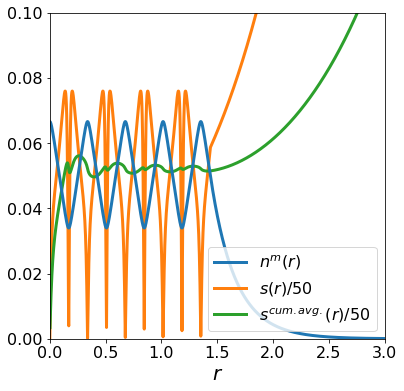

In [5]:
xc = 'gga_c_lyp'
xc_label = 'LYP'
func_c = pylibxc.LibXCFunctional(xc, "unpolarized")
density = functools.partial(monster, r_s_min=1.5, r_s_max=2, s_target=2, num_peaks=5, smoothing_factor=0.05)


grids, n_m, n_m_grad = density(gamma=1)

s = utils.get_s(n_m, n_m_grad)
plt.plot(grids, n_m, label='$n^m(r)$')
plt.plot(grids, s/50, label='$s(r)/50$', zorder=0)
grids_dx = grids[1]-grids[0] 
plt.plot(grids[1:], grids_dx*np.cumsum(s[1:])/grids[1:]/50, label='$s^{cum. avg.}(r)/50$', zorder=1)
  
plt.xlabel('$r$')
plt.legend(loc='lower right')
plt.ylim(0, .1)
plt.xlim(left=0, right=3)

plt.savefig(f'monster_density_{xc_label}.pdf', bbox_inches='tight')

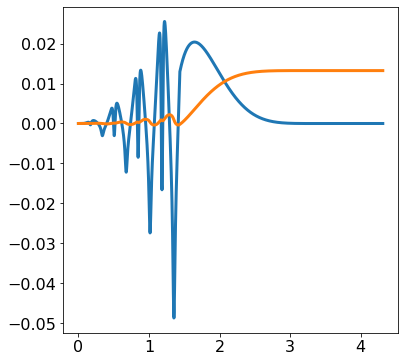

In [13]:
eps_c = get_eps_c(func_c, 1, density)
integrand = 4*pi*eps_c*n_m*(grids**2)


plt.plot(grids, integrand)
plt.plot(grids, grids_dx*np.cumsum(integrand))


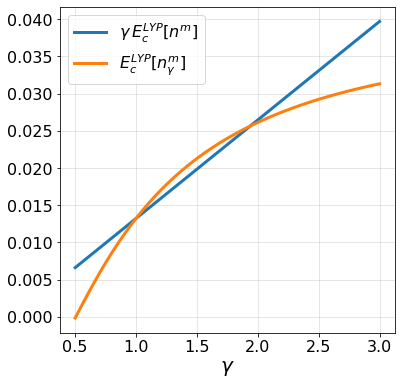

In [ ]:

E_c_gams = []
int_checks = []
gammas = np.linspace(0.5, 3)
for gamma in gammas:

  E_c_gam, int_check = get_E_c_gam(func_c, gamma, density)

  E_c_gams.append(E_c_gam)
  int_checks.append(int_check)

E_c,_ = get_E_c_gam(func_c, 1, density)

plt.plot(gammas, gammas*E_c, label=r'$\gamma \, E^{'+ xc_label +r'}_c[n^m]$')
plt.plot(gammas, E_c_gams, label=r'$E^{'+ xc_label +r'}_c[n^m_{\gamma}]$')

plt.grid(alpha=0.4)
plt.xlabel('$\gamma$')
plt.legend()

plt.savefig(f'monster_corr_scaling_{xc_label}.pdf', bbox_inches='tight')